## Google Driveのマウント

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

ライブラリのインポート

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import copy
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
import os
import datetime
import pytz

データ読み込みの設定（[STL-10データセット](https://ai.stanford.edu/~acoates/stl10/)）

In [2]:
# データに対する前処理を定義
mean = [0.485, 0.456, 0.406] # STL-10画像データの色情報の平均 (R,G,B)
std = [0.229, 0.224, 0.225]  # STL-10画像データの色情報の分散 (R,G,B)
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(96),  # 画像内の一部を切り出し、96x96画素にサイズ変更
        transforms.RandomHorizontalFlip(), # ランダムに選択した画像を水平反転
        transforms.ToTensor(),             # 画像データをPyTorchのtensor型へ変換
        transforms.Normalize(mean, std)    # 画像データの色情報を平均=0、分散=1となるよう標準化
    ])
test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

# データセット読み込み設定
train_dataset = torchvision.datasets.STL10(root='./data/',
                                           split='train', 
                                           transform=train_transform,
                                           download=True)
test_dataset = torchvision.datasets.STL10(root='./data/',
                                          split='test', 
                                          transform=test_transform,
                                          download=True)

100%|██████████| 2640397119/2640397119 [03:35<00:00, 12248530.63it/s]


Extracting ./data/stl10_binary.tar.gz to ./data/
Files already downloaded and verified


データ読み込み

In [3]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False)

画像データ可視化（1バッチ分）

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


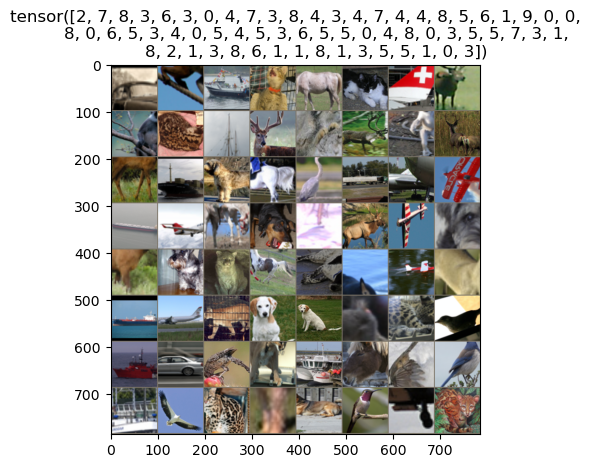

In [4]:
# 訓練データから1バッチ分取り出し
images, labels = next(iter(train_loader))
# グリッド画像作成
out = torchvision.utils.make_grid(images)
# imshow用にチャンネル入れ替え (色,高さ,幅) => (高さ,幅,色)
out = out.numpy().transpose((1, 2, 0))
# 標準化した画像データを表示するためにもとに戻す
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
out = std * out + mean
# 画像表示
plt.imshow(out)
# ラベル表示（0-飛行機, 1-鳥, 2-自動車,・・・）
if labels is not None:
  plt.title(labels)

ネットワークを定義

In [9]:
#分類クラス数
num_classes = 10

#ネットワーク定義
class SampleNet(nn.Module):
  
  def __init__(self, num_classes):
    super(SampleNet, self).__init__()
    self.features = nn.Sequential(
      #チャンネル3->64, 高さ96x幅96->48x48 (カーネルサイズ3の畳み込み層)
      nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      #高さ48x幅48->24x24 (プーリング層)
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
    )
    self.classifier = nn.Sequential(
      #全パラメータの 50 % をゼロにする (ドロップアウト)
      nn.Dropout( p=0.01 ),
      #64*24*24->認識クラス数 (全結合層)
      nn.Linear(512*3*3, 1000),
      nn.ReLU(),
      nn.Linear(1000, 100),
      nn.ReLU(),
      nn.Linear(100, num_classes),
      nn.ReLU(),
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

定義したネットワークをインスタンス化

In [10]:
#GPUにネットワークを転送できるか確認
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#変数netにネットワークをインスタンス化
net = SampleNet(num_classes).to(device)

損失関数と最適化関数

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

訓練

In [12]:
#20エポック
num_epochs = 70

#ベストなパラメータを保存するための変数
best_model = copy.deepcopy(net.state_dict())
best_acc = 0

#ログの保存先設定（TensorBoardプロット用）
dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
now = "{}-{}-{}/{:0=2}-{:0=2}".format(dt_now.year, dt_now.month, dt_now.day, dt_now.hour, dt_now.minute)
log_dir = "drive/My Drive/Colab Notebooks/logs/{}".format(now)
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir=log_dir)

for epoch in range(num_epochs):
  #エポックごとに初期化
  train_loss = 0
  train_acc = 0
  val_loss = 0
  val_acc = 0
    
  #train=============================================
  #訓練モードへ切り替え
  net.train()
  #ミニバッチで分割して読み込む
  for images, labels in train_loader:
    #toでgpuに転送
    images, labels = images.to(device), labels.to(device)        
    #勾配をリセット
    optimizer.zero_grad()
    #順伝播の計算
    outputs = net(images)
    #lossの計算
    loss = criterion(outputs, labels)
    #lossをミニバッチ分積算する
    train_loss += loss.item()
    #accuracyをミニバッチ分積算する
    #正解ラベル（labels）と予測値（outputs.max(1)）が合っている場合に1が返ってくる
    train_acc += (outputs.max(1)[1] == labels).sum().item()
    #逆伝播の計算
    loss.backward()
    #重みの更新
    optimizer.step()
  #平均lossと平均accuracyを計算
  avg_train_loss = train_loss / len(train_loader.dataset)
  avg_train_acc = train_acc / len(train_loader.dataset)

  #ログ保存
  writer.add_scalar("train-loss", avg_train_loss, epoch)
  writer.add_scalar("train-accuracy", avg_train_acc, epoch)
    
  #val=============================================
  #評価モードへ切り替え
  net.eval()
  #勾配計算をオフにする
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = net(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

    #ログ保存
    writer.add_scalar("validation-loss", avg_val_loss, epoch)
    writer.add_scalar("validation-accuracy", avg_val_acc, epoch)

    #ベストなパラメータを保存する
    if avg_val_acc > best_acc:
      best_acc = avg_val_acc
      best_model = copy.deepcopy(net.state_dict())

    #訓練データのlossと検証データのloss, accuracyをログ出力
    print( 'Epoch [{}/{}], train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f},'
      .format(epoch+1, num_epochs, train_loss=avg_train_loss, train_acc=avg_train_acc)
      + 'val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
      .format(val_loss=avg_val_loss, val_acc=avg_val_acc) )

writer.close()

Epoch [1/20], train_loss: 0.0435, train_acc: 0.2032,val_loss: 0.0321, val_acc: 0.2905
Epoch [2/20], train_loss: 0.0303, train_acc: 0.2966,val_loss: 0.0297, val_acc: 0.3326
Epoch [3/20], train_loss: 0.0302, train_acc: 0.2972,val_loss: 0.0279, val_acc: 0.3680
Epoch [4/20], train_loss: 0.0316, train_acc: 0.2892,val_loss: 0.0259, val_acc: 0.4052
Epoch [5/20], train_loss: 0.0291, train_acc: 0.3244,val_loss: 0.0253, val_acc: 0.4200
Epoch [6/20], train_loss: 0.0289, train_acc: 0.3282,val_loss: 0.0239, val_acc: 0.4484
Epoch [7/20], train_loss: 0.0290, train_acc: 0.3330,val_loss: 0.0244, val_acc: 0.4514
Epoch [8/20], train_loss: 0.0295, train_acc: 0.3318,val_loss: 0.0253, val_acc: 0.4209
Epoch [9/20], train_loss: 0.0287, train_acc: 0.3432,val_loss: 0.0246, val_acc: 0.4554
Epoch [10/20], train_loss: 0.0283, train_acc: 0.3572,val_loss: 0.0254, val_acc: 0.4676
Epoch [11/20], train_loss: 0.0295, train_acc: 0.3334,val_loss: 0.0245, val_acc: 0.4462
Epoch [12/20], train_loss: 0.0285, train_acc: 0.3476

推論

In [13]:
#ベストなパラメータを読み込み
net.load_state_dict(best_model)
#推論
net.eval()
with torch.no_grad():
  total = 0
  test_acc = 0
  for images, labels in test_loader:        
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    test_acc += (outputs.max(1)[1] == labels).sum().item()
    total += labels.size(0)
  print('精度: {} %'.format(100 * test_acc / total)) 

精度: 48.775 %


結果をプロット

In [14]:
log_dir = "drive/My Drive/Colab Notebooks/logs/"
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
%tensorboard --logdir "drive/My Drive/Colab Notebooks/logs/"

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.